<a href="https://colab.research.google.com/github/muehlbacher/time-series-analysis-basics/blob/main/timeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.4 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [ ]:
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.compat.v1 as tf1
import math
from scipy.stats import pearsonr, spearmanr

In [ ]:
df = yf.download('^GSPC','1990-01-01','2020-01-01')

[*********************100%***********************]  1 of 1 completed


In [ ]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1990-01-02,353.399994,359.690002,351.980011,359.690002,359.690002,162070000
1990-01-03,359.690002,360.589996,357.890015,358.760010,358.760010,192330000
1990-01-04,358.760010,358.760010,352.890015,355.670013,355.670013,177000000
1990-01-05,355.670013,355.670013,351.350006,352.200012,352.200012,158530000
1990-01-08,352.200012,354.239990,350.540009,353.790009,353.790009,140110000
...,...,...,...,...,...,...
2019-12-24,3225.449951,3226.429932,3220.510010,3223.379883,3223.379883,1296540000
2019-12-26,3227.199951,3240.080078,3227.199951,3239.909912,3239.909912,2160680000
2019-12-27,3247.229980,3247.929932,3234.370117,3240.020020,3240.020020,2428670000


In [ ]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-12-24,3225.449951,3226.429932,3220.510010,3223.379883,3223.379883,1296540000
2019-12-26,3227.199951,3240.080078,3227.199951,3239.909912,3239.909912,2160680000
2019-12-27,3247.229980,3247.929932,3234.370117,3240.020020,3240.020020,2428670000
2019-12-30,3240.090088,3240.919922,3216.570068,3221.290039,3221.290039,3013290000
2019-12-31,3215.179932,3231.719971,3212.030029,3230.780029,3230.780029,2893810000


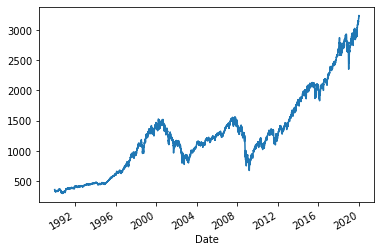

In [ ]:
df.Close.plot()

[Text(0, 0, 'Monday'),
 Text(0, 0, 'Tuesday'),
 Text(0, 0, 'Wednesday'),
 Text(0, 0, 'Thursday'),
 Text(0, 0, 'Friday')]

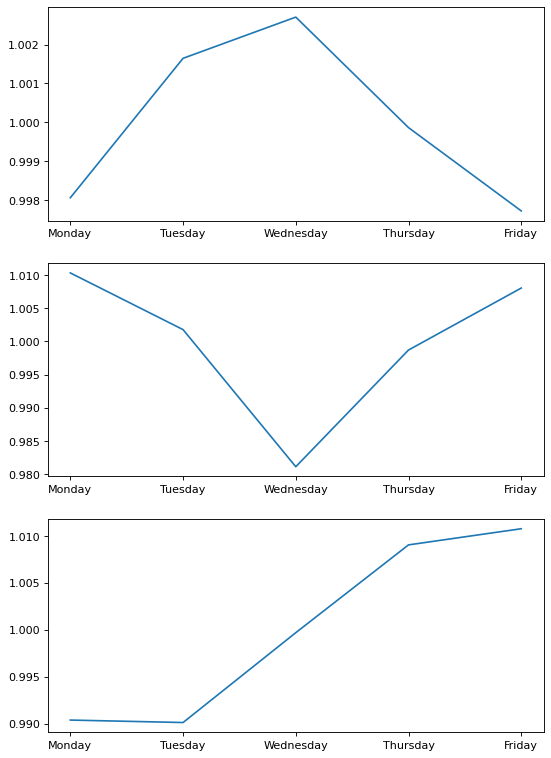

In [ ]:
## pick three weeks (Mon - Fri) from different years
## scale closing prices for each day by teh week's mean closing price

fig, axs = plt.subplots(3, 1, figsize = (8,12), dpi = 80)

plt.subplots_adjust(hspace=0.2)
## 1993
vals = df['1993-05-03':'1993-05-07'].Close.values
mean_val = np.mean(vals)
axs[0].plot([1,2,3,4,5], vals/mean_val)
axs[0].set_xticks([1,2,3,4,5])
axs[0].set_xticklabels(['Monday', 'Tuesday', 'Wednesday','Thursday', 'Friday'])


## 2000
vals = df['2000-05-08':'2000-05-12'].Close.values
mean_val = np.mean(vals)
axs[1].plot([1,2,3,4,5], vals/mean_val)
axs[1].set_xticks([1,2,3,4,5])
axs[1].set_xticklabels(['Monday', 'Tuesday', 'Wednesday','Thursday', 'Friday'])

## 2018
vals = df['2018-05-07':'2018-05-11'].Close.values
mean_val = np.mean(vals)
axs[2].plot([1,2,3,4,5], vals/mean_val)
axs[2].set_xticks([1,2,3,4,5])
axs[2].set_xticklabels(['Monday', 'Tuesday', 'Wednesday','Thursday', 'Friday'])




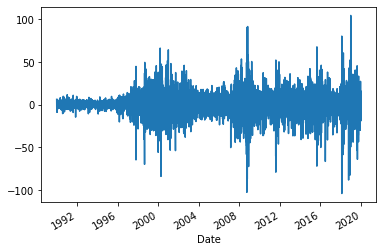

In [ ]:
#Compute Daily Return
df['Return'] = df.Close - df.Open
df.Return.plot()

The figure above shows that, this alone is not enoug to make the data comparable. We will also have to find a way to normalize the data without a lookahead so taht the values we are using for inputs and outputs into our model are more even throughout the tie period of interest. (p. 408)

### Preprocessing Financial Data for Deep Learning
Our data preprocessing will be done in three steps:
1. We will form new, economically meaningful quantities of interes out of the raw inputs.
2. We will compute an exponentially weighted moving average and variance of the quantities of interest so that we can scale them without a lookahead.
3. We will package our results in a format appropriate for hte recurrent deep learning model we will us to fit the data.


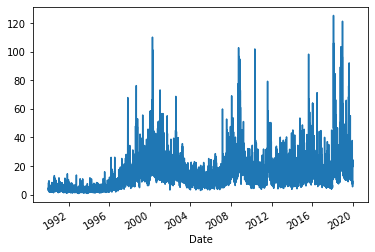

In [ ]:
## Adding quantities of interest
df['DailyVolatility'] = df.High - df.Low
df.DailyVolatility.plot()

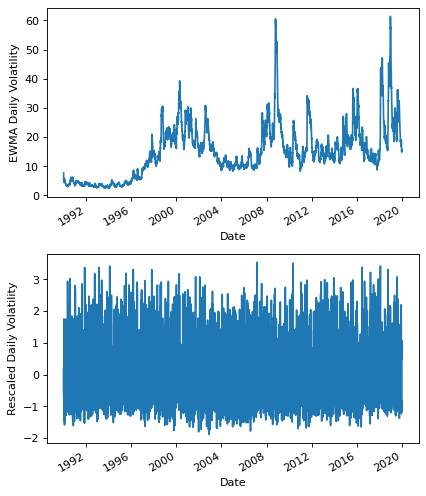

In [ ]:
## Scaling Quantities of Interest without a Lookahead
#exponentially weighted moving average of every column in the data frame
#### Halflife as Hyperparameter for the model - the model behavior will certainly depend on this parameter
HALF_LIFE = 10
figure, axes = plt.subplots(2, 1, figsize = (6,8), dpi = 80)
plt.subplots_adjust(hspace=0.3)
#ewm average
ewdf = df.ewm(halflife = HALF_LIFE).mean()
axes[0].set_ylabel("EWMA Daily Volatility")
ewdf.DailyVolatility.plot(ax=axes[0])

#ewm variance
vewdf = df.ewm(halflife = HALF_LIFE).var()
#scale by demeaning and normalizing
scaled = df.DailyVolatility - ewdf.DailyVolatility
scaled = scaled / vewdf.DailyVolatility**0.5
axes[1].set_ylabel("Rescaled Daily Volatility")
scaled.plot(ax=axes[1])

In [ ]:
##We transform all three raw inputs of interest into a scaled version:

df['ScaledVolatility'] = ((df.DailyVolatility - ewdf.DailyVolatility) / vewdf.DailyVolatility**0.5)
df['ScaledReturn'] = ((df.Return - ewdf.Return) / vewdf.Return**0.5)
df['ScaledVolume'] = ((df.Volume - ewdf.Volume) / vewdf.Volume**0.5)

#Finally drop the NA results that come from exponentaial smoothing
df = df.dropna()

In [ ]:
## break our data into training and testing components
train_df = df[:7000]
test_df= df[7000:]

## building our pipeline variables off training data
## taking only values of interest from larger data frames
HORIZON = 10
X = train_df[:(7000 - HORIZON)][["ScaledVolatility", "ScaledReturn", "ScaledVolume"]].values
Y = train_df[HORIZON:]["ScaledReturn"].values

In [ ]:
##TNC - We want to add a third dimension, axis 1 (so pushing the second dimension out to axis 2, where the axes are numbered from 0 up)
## Our temporal axis is already axis 0 because the data frame was sorted temporally. The last axis, now axis 2, is already the "channel axis" because
## our inputs each occupy one column of that dimension.
X = np.expand_dims(X, axis = 1)

In [ ]:
##We will try a model that will see 10 time steps - that is 10 days of data looking backward.
## So we need to cut off axis 0 to be of length 10.

X = np.split(X, X.shape[0]/HORIZON, axis = 0)
X = np.concatenate(X, axis = 1)
X.shape

(10, 699, 3)

In [ ]:
num_to_unpack = math.floor(X.shape[0]/WINDOW_SIZE)
start_idx = X.shape[0] - num_to_unpack * WINDOW_SIZE

In [ ]:
start_idx

10

In [ ]:
X_new, Y_new = timeseriesdata(X, Y,WINDOW_SIZE, 3)

In [ ]:
print(X)

[[-0.68261013 -0.68261013  0.68261013]
 [ 0.19341612 -0.74806494 -0.03132525]
 [-0.37088986 -0.65783218 -0.88773674]
 ...
 [ 0.62209053 -0.47422429  0.11654754]
 [-0.425039   -0.63625535 -0.4164925 ]
 [ 0.85321249  0.41791392  0.48000578]]


In [ ]:
print(X_new)

[[[-0.68261013 -0.68261013  0.68261013]
  [ 0.19341612 -0.74806494 -0.03132525]
  [-0.37088986 -0.65783218 -0.88773674]
  ...
  [-0.27347573 -0.00216278 -1.31270073]
  [-0.47749172 -0.12974931 -1.01413197]
  [ 0.97661944  1.37076973 -0.81609145]]

 [[ 0.19341612 -0.74806494 -0.03132525]
  [-0.37088986 -0.65783218 -0.88773674]
  [-0.56904634  0.42824051 -1.23838937]
  ...
  [-0.47749172 -0.12974931 -1.01413197]
  [ 0.97661944  1.37076973 -0.81609145]
  [ 0.34119473  1.03132462 -0.99868815]]

 [[-0.37088986 -0.65783218 -0.88773674]
  [-0.56904634  0.42824051 -1.23838937]
  [-0.10324238 -0.8602706  -0.4300406 ]
  ...
  [ 0.97661944  1.37076973 -0.81609145]
  [ 0.34119473  1.03132462 -0.99868815]
  [-0.25142163  0.75797602  0.72994151]]

 ...

 [[ 0.62363704  0.36940533  1.19430769]
  [-0.10097986  0.27053275 -1.09780636]
  [ 0.07499333 -0.18590796  0.62767788]
  ...
  [ 0.16818277  0.00459382  0.48528822]
  [-0.46652682 -0.92945634 -0.69383557]
  [-0.6394878   0.49662052 -0.78127015]]

 [

In [ ]:
print(Y)

[-0.45857495  0.54700852  0.54930039 ... -1.30447433 -0.2265668
  0.35913704]


In [ ]:
print(Y_new)

[ 1.81708188  0.1609535   0.7578958  ... -1.30447433 -0.2265668
  0.35913704]


Given the TNC format, we have time series of length 10 (HORIZON), with three parallel inputs (Scaled Volatility, Scaled Return, Scaled Volume). Of these we have 699 examples. The batch size will determine how many batches make up an epoch, where an epoch is one cycle through our data.

In [ ]:
def timeseriesdata(X, Y,win, channel):
    ###takes 2 dimensional array time series - transform it to TNC (time,sample,channel)
    ##takes 1 dimensional array of labels - transforms it to fit the TNC Data
    X = np.expand_dims(X, axis = 1)
    X_tnc = np.zeros((win,X.shape[0] - win + 1, channel))
    for i, _ in enumerate(X):
        try:
            X_tnc[:,i:i+1,:] = X[i:i+win]
        except:
            break   
    return X_tnc[:,0:X_tnc.shape[1]-1,:], Y[win:]

### Building and Training an RNN

In [ ]:
## architecture parameters
NUM_HIDDEN = 5
NUM_LAYERS = 2

## data formatting parameters
BATCH_SIZE = 64
WINDOW_SIZE = 20

## training parameters
LEARNING_RATE = 1e-2
EPOCHS = 10

In [ ]:
tf.compat.v1.disable_eager_execution()


Xinp = tf1.placeholder(dtype = tf.float32, shape = [WINDOW_SIZE, None, 3])
Yinp = tf1.placeholder(dtype = tf.float32, shape = [None])

In [ ]:
with tf1.variable_scope("scope1", reuse = tf1.AUTO_REUSE):
  cells = [tf1.nn.rnn_cell.LSTMCell(num_units = NUM_HIDDEN) for n in range(NUM_LAYERS)]
  stacked_rnn_cell = tf1.nn.rnn_cell.MultiRNNCell(cells)
  rnn_output, states = tf1.nn.dynamic_rnn(stacked_rnn_cell, Xinp, dtype = tf.float32)
  W = tf1.get_variable("W_fc", [NUM_HIDDEN, 1], initializer = tf.random_uniform_initializer(-.2, .2))

  ## notice we have not bias because we expect average zero return
  output = tf.squeeze(tf.matmul(rnn_output[-1, : , :], W))

  loss = tf.nn.l2_loss(output - Yinp)
  opt = tf1.train.GradientDescentOptimizer(LEARNING_RATE)
  train_step = opt.minimize(loss)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
/usr/local/lib/python3.7/dist-packages/keras/layers/legacy_rnn/rnn_cell_impl.py:988: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  partitioner=maybe_partitioner)
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
/usr/local/lib/python3.7/dist-packages/keras/layers/legacy_rnn/rnn_cell_impl.py:996: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  initializer=initializer)


In [ ]:
sess = tf1.Session()
sess.run(tf1.tables_initializer())
sess.run(tf1.global_variables_initializer())

In [ ]:

## for each epoch

y_hat_dict = {}
Y_dict = {}

in_sample_Y_dict = {}
in_sample_y_hat_dict = {}

for ep in range(EPOCHS):
  epoch_training_loss = 0.0
  for i in range(WINDOW_SIZE):
    X = train_df[:(7000- WINDOW_SIZE)][["ScaledVolatility", "ScaledReturn", "ScaledVolume"]].values
    Y = train_df[WINDOW_SIZE:]["ScaledReturn"].values

    ## make it divisible by window size
    #num_to_unpack = math.floor(X.shape[0]/WINDOW_SIZE)
    #start_idx = X.shape[0] - num_to_unpack * WINDOW_SIZE
    X,Y = timeseriesdata(X, Y,WINDOW_SIZE, 3)

    ##TRAINING
    ## now we batch it and run a sess
    for j in range(math.ceil(Y.shape[0] / BATCH_SIZE)):
      ll = BATCH_SIZE * j
      ul = BATCH_SIZE * (j + 1)

      if ul > X.shape[1]:
        ul = X.shape[1] - 1
        ll = X.shape[1] - BATCH_SIZE
      
      training_loss, _, y_hat = sess.run([loss, train_step, output],
                                  feed_dict = {
                                      Xinp: X[:, ll:ul, :], Yinp: Y[ll:ul]
                                  })
      epoch_training_loss += training_loss          
      
      in_sample_Y_dict[ep]     = Y[ll:ul] ## notice this will only net us the last part of data trained on
      in_sample_y_hat_dict[ep] = y_hat
        
    ## TESTING
    X = test_df[:(test_df.shape[0] - WINDOW_SIZE)][["ScaledVolatility", "ScaledReturn", "ScaledVolume"]].values
    Y = test_df[WINDOW_SIZE:]["ScaledReturn"].values
    num_to_unpack = math.floor(X.shape[0] / WINDOW_SIZE)
    start_idx = X.shape[0] - num_to_unpack * WINDOW_SIZE
    X = X[start_idx:] ## better to throw away beginning than end of training period when must delete
    Y = Y[start_idx:]                              
    
    X = np.expand_dims(X, axis = 1)
    X = np.split(X, X.shape[0]/WINDOW_SIZE, axis = 0)
    X = np.concatenate(X, axis = 1)

    #Y[start:stop:step]
    Y = Y[::WINDOW_SIZE]
    testing_loss, y_hat = sess.run([loss, output],
                              feed_dict = { Xinp: X, Yinp: Y })
    ## nb this is not great. we should really have a validation loss apart from testing
    
  print("Epoch: %d   Training loss: %0.2f   Testing loss %0.2f:" % (ep, epoch_training_loss, testing_loss))
  Y_dict[ep] = Y
  y_hat_dict[ep] = y_hat


Epoch: 0   Training loss: 57083.01   Testing loss 14.62:
Epoch: 1   Training loss: 56591.07   Testing loss 15.13:
Epoch: 2   Training loss: 56274.53   Testing loss 14.67:
Epoch: 3   Training loss: 55968.75   Testing loss 14.27:
Epoch: 4   Training loss: 55678.87   Testing loss 14.37:
Epoch: 5   Training loss: 55612.06   Testing loss 14.01:
Epoch: 6   Training loss: 55185.83   Testing loss 13.82:
Epoch: 7   Training loss: 54876.09   Testing loss 13.73:
Epoch: 8   Training loss: 55739.93   Testing loss 13.32:
Epoch: 9   Training loss: 58340.92   Testing loss 13.35:


In [ ]:
## for each epoch

y_hat_dict = {}
Y_dict = {}

in_sample_Y_dict = {}
in_sample_y_hat_dict = {}
print(X.shape)
print(X)
for ep in range(EPOCHS):
  epoch_training_loss = 0.0
  for i in range(WINDOW_SIZE):
    print(f"i:{i}")
    X = train_df[:(7000- WINDOW_SIZE)][["ScaledVolatility", "ScaledReturn", "ScaledVolume"]].values
    print(X.shape)
    Y = train_df[WINDOW_SIZE:]["ScaledReturn"].values

    ## make it divisible by window size
    num_to_unpack = math.floor(X.shape[0]/WINDOW_SIZE)
    print(f"num_to_unpack:{num_to_unpack}")
    start_idx = X.shape[0] - num_to_unpack * WINDOW_SIZE
    print(f"start_idx:{start_idx}")
    X = X[start_idx:]
    Y = Y[start_idx:]

    print(f"WINDOW_SIZE-i: {WINDOW_SIZE-i}")
    X = X[i: -(WINDOW_SIZE-i)]
    #print(X)
    Y = Y[i: -(WINDOW_SIZE-i)]
    print(X.shape)
    X = np.expand_dims(X, axis = 1)

    ##np.split(x, [2])
    ##x= [1,2,3,4]
    ##[1,2] [3,4]
    X = np.split(X, X.shape[0]/WINDOW_SIZE, axis = 0)
    X = np.concatenate(X, axis = 1)

    ##Y[start:stop:step]
    Y = Y[::WINDOW_SIZE]

    ##TRAINING
    ## now we batch it and run a sess
    for j in range(math.ceil(Y.shape[0] / BATCH_SIZE)):
      ll = BATCH_SIZE * j
      ul = BATCH_SIZE * (j + 1)

      if ul > X.shape[1]:
        ul = X.shape[1] - 1
        ll = X.shape[1] - BATCH_SIZE
      
      training_loss, _, y_hat = sess.run([loss, train_step, output],
                                  feed_dict = {
                                      Xinp: X[:, ll:ul, :], Yinp: Y[ll:ul]
                                  })
      epoch_training_loss += training_loss          
      
      in_sample_Y_dict[ep]     = Y[ll:ul] ## notice this will only net us the last part of data trained on
      in_sample_y_hat_dict[ep] = y_hat
        
    ## TESTING
    X = test_df[:(test_df.shape[0] - WINDOW_SIZE)][["ScaledVolatility", "ScaledReturn", "ScaledVolume"]].values
    Y = test_df[WINDOW_SIZE:]["ScaledReturn"].values
    num_to_unpack = math.floor(X.shape[0] / WINDOW_SIZE)
    start_idx = X.shape[0] - num_to_unpack * WINDOW_SIZE
    X = X[start_idx:] ## better to throw away beginning than end of training period when must delete
    Y = Y[start_idx:]                              
    
    X = np.expand_dims(X, axis = 1)
    X = np.split(X, X.shape[0]/WINDOW_SIZE, axis = 0)
    X = np.concatenate(X, axis = 1)

    #Y[start:stop:step]
    Y = Y[::WINDOW_SIZE]
    testing_loss, y_hat = sess.run([loss, output],
                              feed_dict = { Xinp: X, Yinp: Y })
    ## nb this is not great. we should really have a validation loss apart from testing
    
  print("Epoch: %d   Training loss: %0.2f   Testing loss %0.2f:" % (ep, epoch_training_loss, testing_loss))
  Y_dict[ep] = Y
  y_hat_dict[ep] = y_hat


(10, 699, 3)
[[[-6.82610135e-01 -6.82610135e-01  6.82610135e-01]
  [ 2.21575421e-01 -4.58574954e-01  2.31360738e-01]
  [ 1.66206108e-01  1.81708188e+00  7.57190125e-01]
  ...
  [-1.38462390e-01  4.14066697e-02 -7.77316213e-01]
  [ 3.41194726e-01  1.03132462e+00 -9.98688145e-01]
  [-7.63135169e-01 -1.68702696e-02  7.18816623e-01]]

 [[ 1.93416118e-01 -7.48064935e-01 -3.13252490e-02]
  [-4.09084320e-01  5.47008519e-01  6.40606821e-01]
  [-1.58480006e+00  1.60953504e-01 -9.83509163e-01]
  ...
  [ 2.57143945e+00 -2.57189776e+00 -2.99383557e-01]
  [-2.51421627e-01  7.57976022e-01  7.29941508e-01]
  [-7.24038402e-01  3.53480093e-01  2.90502591e+00]]

 [[-3.70889861e-01 -6.57832184e-01 -8.87736736e-01]
  [-1.25976327e+00  5.49300393e-01  9.41084632e-01]
  [-6.44842574e-01  7.57895797e-01 -4.48013674e-01]
  ...
  [ 6.91780565e-01  7.74312808e-02  3.80356201e-01]
  [-1.03663667e+00  1.22898684e-01 -8.20851672e-01]
  [-4.96422302e-01 -8.48659055e-03 -1.55597202e-01]]

 ...

 [[ 1.74118644e+00 -1

In [ ]:
test_df.shape

(558, 11)

In [ ]:
test_df.shape[0]/20

27.9

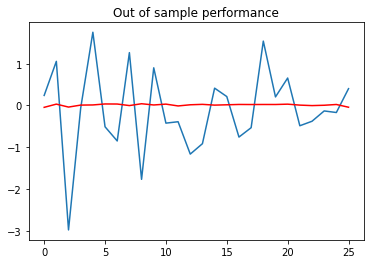

In [ ]:
plt.plot(Y_dict[EPOCHS - 1])
plt.plot(y_hat_dict[EPOCHS - 1], 'r')
plt.title('Out of sample performance')
plt.show()

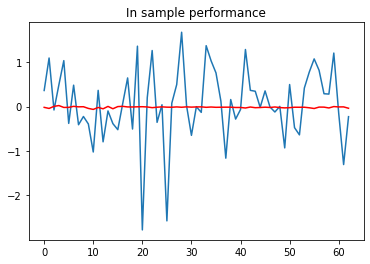

In [ ]:
plt.plot(in_sample_Y_dict[EPOCHS - 1])
plt.plot(in_sample_y_hat_dict[EPOCHS - 1], 'r')
plt.title('In sample performance')
plt.show()

In [ ]:
pearsonr(Y_dict[EPOCHS - 1], y_hat_dict[EPOCHS - 1])

(0.06541548682976393, 0.7508714712547568)

In [ ]:
pearsonr(in_sample_Y_dict[EPOCHS - 1], in_sample_y_hat_dict[EPOCHS - 1])

(0.010423770971918031, 0.9353771378422817)

In [ ]:
spearmanr(Y_dict[EPOCHS - 1], y_hat_dict[EPOCHS - 1])

SpearmanrResult(correlation=-0.23965811965811962, pvalue=0.23831737625711377)

In [ ]:
spearmanr(in_sample_Y_dict[EPOCHS - 1], in_sample_y_hat_dict[EPOCHS - 1])

SpearmanrResult(correlation=-0.048147081413210446, pvalue=0.7078684122401119)

In [ ]:
Y_dict[9]

array([ 0.24026073,  1.05686496, -2.98071546, -0.06238862,  1.75398573,
       -0.51044935, -0.8499937 ,  1.26578459, -1.76913153,  0.90195343,
       -0.42306792, -0.38944866, -1.16469003, -0.91517446,  0.41451642,
        0.21365333, -0.75671554, -0.53219442,  1.54157984,  0.2050859 ,
        0.65725016, -0.48571971, -0.37812007, -0.13105888, -0.16870818,
        0.40279633])

In [ ]:
y_hat_dict[9]

array([-0.0447878 ,  0.03221688, -0.03833469,  0.00913907,  0.01259683,
        0.03615915,  0.03462373, -0.00243666,  0.04143857,  0.01203221,
        0.032295  , -0.01125792,  0.01667314,  0.02671687,  0.00861971,
        0.01619226,  0.02435263,  0.02264171,  0.02379264,  0.0233735 ,
        0.03133363,  0.00863563, -0.00292461,  0.00521183,  0.02366586,
       -0.04200389], dtype=float32)

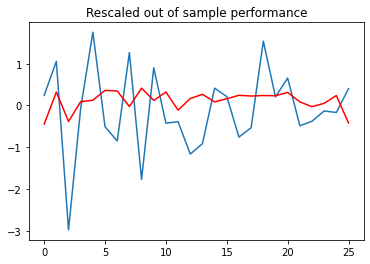

In [ ]:
plt.plot(Y_dict[EPOCHS - 1])
plt.plot(y_hat_dict[EPOCHS - 1] * 10, 'r')
plt.title('Rescaled out of sample performance')
plt.show()

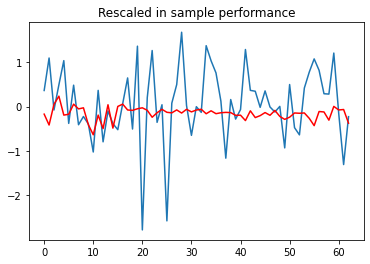

In [ ]:
plt.plot(in_sample_Y_dict[EPOCHS - 1])
plt.plot(in_sample_y_hat_dict[EPOCHS - 1] * 10, 'r')
plt.title('Rescaled in sample performance')
plt.show()

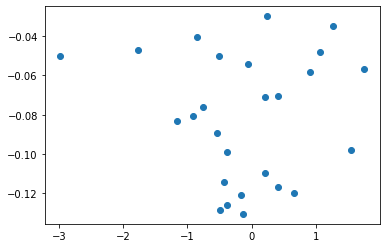

In [ ]:
plt.plot(Y_dict[EPOCHS - 1], y_hat_dict[EPOCHS - 1] * 10, linestyle="", marker="o")


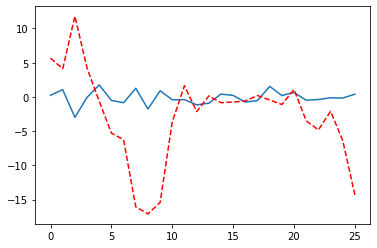

In [ ]:
plt.plot(Y_dict[EPOCHS-1][:100])
plt.plot(y_hat_dict[EPOCHS-1][:100] * 50, 'r--')
plt.show()

In [ ]:
X.shape[0]

20

In [ ]:
math.ceil(Y.shape[0] / BATCH_SIZE)

1

In [ ]:
Y.shape[0] / BATCH_SIZE

0.40625